# Case Study - User Ranking  

In [ ]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', None)
import pandas_profiling
from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

### Helper functions

In [2]:
def feature_distribution(df, feature):
    feature_df = df.groupby([feature]).size().reset_index(name='# of ' + feature)
    feature_df.set_index(feature, inplace=True)
    feature_df.plot(y='# of ' + feature, kind='pie', autopct="%1.1f%%",figsize=(10, 10));

def cat2num(df, cols):
    df[cols] = df[cols].astype('category')
    df[cols] = df[cols].apply(lambda x: x.cat.codes)
    return df

## **Preprocessing**

### Read data

In [3]:
df = pd.read_csv('../data/data_Nov_2022.csv')
df

,person-id,timestamp,search-id,search-ranking,countries,email-domains,outreach-success
0,93033378-8207-4c9f-bfa5-95b520f7c760,2021-05-26T14:31:54.307000,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1,US,ub.edu,0
1,18a3bd6b-5665-4f08-aae4-66f2219100b3,2021-05-26T14:31:54.307000,a6380bba-b203-48dc-bbd6-5cb58b12ee07,2,US,bcm.edu,0
2,21e9d97a-0940-4fcf-825a-e4a118d01b1b,2021-05-26T14:31:54.307000,a6380bba-b203-48dc-bbd6-5cb58b12ee07,3,US,nemours.org,0
3,aUlZWRzbXY7Ev5VCWo8Zag_0000,2021-05-26T14:31:54.307000,a6380bba-b203-48dc-bbd6-5cb58b12ee07,4,US,"mssm.edu,sangabrieleye.com,usc.edu",0
4,2e23c461-d817-4d6c-af0b-b3567e63b878,2021-05-26T14:31:54.307000,a6380bba-b203-48dc-bbd6-5cb58b12ee07,5,US,"ucsf.edu,virginia.edu",0
...,...,...,...,...,...,...,...
371799,1fdc9fe9-b2bf-49fd-a205-5182eb8a2816,2021-05-18T11:17:37.625000,f18d6829-5eb8-4df1-bd56-40a383f2a5d8,996,US,"unc.edu,med.unc.edu",0
371800,a150e234-1452-4211-b6c3-efd1c6003056,2021-05-18T11:17:37.625000,f18d6829-5eb8-4df1-bd56-40a383f2a5d8,997,US,msx.upmc.edu,0
371801,668dd801-9b5d-4969-a2c5-9e694bdcc006,2021-05-18T11:17:37.625000,f18d6829-5eb8-4df1-bd56-40a383f2a5d8,998,US,omrf.org,0
371802,57900bb4-fb62-4a07-949b-b4f27d04e8b9,2021-05-18T11:17:37.625000,f18d6829-5eb8-4df1-bd56-40a383f2a5d8,999,US,hss.edu,0


### Convert timestamp type

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dtypes

person-id                   object
timestamp           datetime64[ns]
search-id                   object
search-ranking               int64
countries                   object
email-domains               object
outreach-success             int64
dtype: object

### Understanding data
Using pandas-profiling we can extend `df.describe` or relevant methods that provide limited usage for exploratory data analysis.

In [5]:
# profile = ProfileReport(df, title='Data Profiling')
# profile.to_file("data/data_profiling.html")

Opening the report on a browser we can get a useful overview of our data and some info like the distribution of values of timestamps, search-ids and ranking. We also see that there is no correlation between variables and we notice the high imbalance on the target variable('outreach-success'), which will guide us on how to continue our study.

For the sake of the task and the exploration, we will reproduce some of these info inside this notebook.

### The features are too few to predict outreach success or re-rank profiles, but we will try to create new features and valuable input for modeling

### Check final outreach-success distribution (target variable)

In [6]:
df['outreach-success'].value_counts()

0    370270
1      1534
Name: outreach-success, dtype: int64

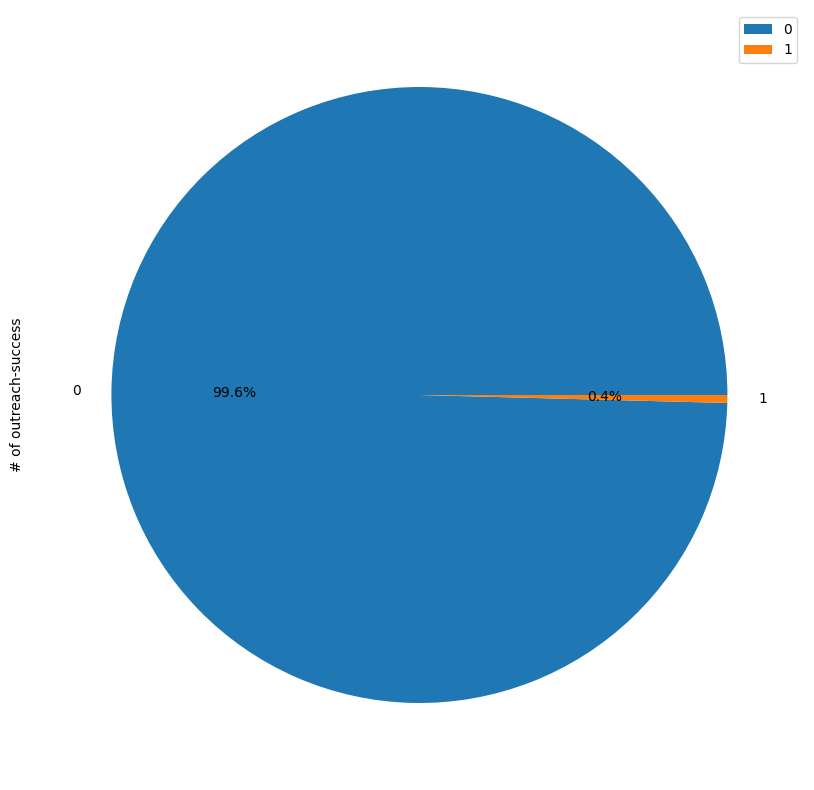

In [7]:
feature_distribution(df, 'outreach-success')

### Count null values per column

In [8]:
df.isna().sum()

person-id            0
timestamp            0
search-id            0
search-ranking       0
countries           10
email-domains       11
outreach-success     0
dtype: int64

### Check for null values on minority class

In [9]:
success_df = df[df['outreach-success']==1]
success_df.isna().sum()

person-id           0
timestamp           0
search-id           0
search-ranking      0
countries           0
email-domains       0
outreach-success    0
dtype: int64

### Explore minority class

In [10]:
# profile = ProfileReport(success_df, title='Outreach-success Data Profiling')
# profile.to_file("data/success_profiling.html")

### Shorten dataset in order to save time for the following calculations (adding useful variables)

In [11]:
non_success_df = df[df['outreach-success']==0].sample(n=len(success_df), random_state=42)
non_success_df

,person-id,timestamp,search-id,search-ranking,countries,email-domains,outreach-success
211165,73c2b3fe-c209-47a2-b154-c223591e79de,2021-05-28 11:40:00.182,238b2beb-b140-423d-8a89-db85b0fd639f,3314,US,grc.nia.nih.gov,0
233593,f86aaf35-a0f4-4982-a72b-0b8f6b936bf5,2021-05-13 14:50:54.887,4cf03b4d-8b55-48d6-bebf-a93296e6b071,992,US,mayo.edu,0
352729,410e95d1-9623-4370-b23a-33648ac4fab4,2021-05-26 13:30:42.212,07c48bc2-e992-4315-85cb-bfcc5397846d,1326,US,"osumc.edu,dartmouth.edu",0
199808,230c2784-e5ea-4d78-952b-bfe47f476240,2021-05-10 09:29:15.492,de54440d-8475-4d82-8c92-ff5c70f6681a,1257,US,hsc.utah.edu,0
73192,ee36467e-1e71-4a11-9114-0f44d9579161,2021-05-26 13:25:13.995,f1de1e7a-abc2-42df-b823-92c7bda83817,392,US,mail.nih.gov,0
...,...,...,...,...,...,...,...
263653,98804212-0380-4650-95ac-46f4dadf2988,2021-05-25 13:26:40.407,1561d34c-4af3-40d5-8773-47e8b88b4461,1151,US,excsci.umass.edu,0
63918,da23ca82-8731-4b8a-9353-99f2bbbae145,2021-05-20 15:31:18.485,c9129384-f2e2-4eff-92e0-80b0e5dd6361,118,FR,echo-sante.com,0
263742,b15ae104-a0b7-4d7d-a67b-27dd6907dd1d,2021-05-25 13:26:40.407,1561d34c-4af3-40d5-8773-47e8b88b4461,1240,US,miami.edu,0
148281,84053dd7-f90b-4d94-bcca-925eb1376c4c,2021-05-05 09:20:13.608,73725cea-e829-4b67-b025-ec526cc260ab,1181,DE,em.mpg.de,0


### Merge two subsets on a new dataframe

In [12]:
df = pd.concat([success_df, non_success_df], ignore_index=True)
df

,person-id,timestamp,search-id,search-ranking,countries,email-domains,outreach-success
0,jZBg1Skm2HxoTeGpoCtguA_0000,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1006,US,"yahoo.com,allergan.com,shire.com,alumni.usc.edu",1
1,28b7da47-690b-4ff4-89fd-de9d315e859b,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1009,US,"yahoo.com,kalarx.com,shire.com",1
2,425ba450-4a21-4f23-bdab-8e1dad6d704f,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1099,US,usc.edu,1
3,ZpVOnXd7BGnBVBwIsywUOQ_0000,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1128,US,"allergan.com,matitherapeutics.com",1
4,B6Hx8JCgZuobdI0-I02awg_0000,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1165,US,"yahoo.com,imprimispharma.com",1
...,...,...,...,...,...,...,...
3063,98804212-0380-4650-95ac-46f4dadf2988,2021-05-25 13:26:40.407,1561d34c-4af3-40d5-8773-47e8b88b4461,1151,US,excsci.umass.edu,0
3064,da23ca82-8731-4b8a-9353-99f2bbbae145,2021-05-20 15:31:18.485,c9129384-f2e2-4eff-92e0-80b0e5dd6361,118,FR,echo-sante.com,0
3065,b15ae104-a0b7-4d7d-a67b-27dd6907dd1d,2021-05-25 13:26:40.407,1561d34c-4af3-40d5-8773-47e8b88b4461,1240,US,miami.edu,0
3066,84053dd7-f90b-4d94-bcca-925eb1376c4c,2021-05-05 09:20:13.608,73725cea-e829-4b67-b025-ec526cc260ab,1181,DE,em.mpg.de,0


### **So, now we have a short balanced version of the first dataframe**

### Create new features in case the expert was previously contacted. Include number of contacts and time passed since last one.
A first thought would be to check if experts have been previously contacted and how the responded after some times. So, we record this info to three new columns.

In [13]:
cnt=0
def calc_previous(outer_personid, inner_personid, outer_timestamp, inner_timestamp, previous_contact, num_previous_contact, days_passed_from_previous):
    global cnt
    cnt+=1
    if outer_personid==inner_personid:
        if (outer_timestamp==inner_timestamp):
            return previous_contact, num_previous_contact, days_passed_from_previous
        elif (outer_timestamp<inner_timestamp):
            previous_contact=1
            num_previous_contact+=1
            days_passed_from_previous = (inner_timestamp-outer_timestamp).days
    return previous_contact, num_previous_contact, days_passed_from_previous

temp_df = df.copy()
temp_df['previous_contact']= 0
temp_df['num_previous_contacts']= 0
temp_df['days_passed_from_previous']= 0


start = time.time()
for outer_personid, outer_timestamp in zip(df["person-id"],df['timestamp']):
    temp_df['previous_contact'], temp_df['num_previous_contacts'], temp_df['days_passed_from_previous'] = \
        zip(*temp_df.apply(lambda row: calc_previous(outer_personid, row['person-id'], outer_timestamp, \
            row.timestamp, row.previous_contact, row.num_previous_contacts, row.days_passed_from_previous), axis=1))
print('time: ', time.time()-start)
temp_df
cnt

time:  291.5650005340576


,person-id,timestamp,search-id,search-ranking,countries,email-domains,outreach-success,previous_contact,num_previous_contacts,days_passed_from_previous
0,jZBg1Skm2HxoTeGpoCtguA_0000,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1006,US,"yahoo.com,allergan.com,shire.com,alumni.usc.edu",1,0,0,0
1,28b7da47-690b-4ff4-89fd-de9d315e859b,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1009,US,"yahoo.com,kalarx.com,shire.com",1,0,0,0
2,425ba450-4a21-4f23-bdab-8e1dad6d704f,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1099,US,usc.edu,1,0,0,0
3,ZpVOnXd7BGnBVBwIsywUOQ_0000,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1128,US,"allergan.com,matitherapeutics.com",1,0,0,0
4,B6Hx8JCgZuobdI0-I02awg_0000,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1165,US,"yahoo.com,imprimispharma.com",1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3063,98804212-0380-4650-95ac-46f4dadf2988,2021-05-25 13:26:40.407,1561d34c-4af3-40d5-8773-47e8b88b4461,1151,US,excsci.umass.edu,0,0,0,0
3064,da23ca82-8731-4b8a-9353-99f2bbbae145,2021-05-20 15:31:18.485,c9129384-f2e2-4eff-92e0-80b0e5dd6361,118,FR,echo-sante.com,0,0,0,0
3065,b15ae104-a0b7-4d7d-a67b-27dd6907dd1d,2021-05-25 13:26:40.407,1561d34c-4af3-40d5-8773-47e8b88b4461,1240,US,miami.edu,0,0,0,0
3066,84053dd7-f90b-4d94-bcca-925eb1376c4c,2021-05-05 09:20:13.608,73725cea-e829-4b67-b025-ec526cc260ab,1181,DE,em.mpg.de,0,0,0,0


9412624

In [14]:
temp_df.rename(columns={'time_passed_from_previous':'days_passed_from_previous'}, inplace=True)
# temp_df[temp_df['previous_contact']==1]

### We can create new features out of timestamp, like the hour of the day,day of week and month, to detect behavior profiling.
We will keep them as numerical and non categorical in order to hold their cyclical attributes.

In [15]:
temp_df['hour_of_day'] = temp_df['timestamp'].dt.hour
temp_df['day_of_week'] = temp_df['timestamp'].dt.day_of_week
temp_df['month'] = temp_df['timestamp'].dt.month
# temp_df.drop('timestamp', axis=1, inplace=True)
temp_df

,person-id,timestamp,search-id,search-ranking,countries,email-domains,outreach-success,previous_contact,num_previous_contacts,days_passed_from_previous,hour_of_day,day_of_week,month
0,jZBg1Skm2HxoTeGpoCtguA_0000,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1006,US,"yahoo.com,allergan.com,shire.com,alumni.usc.edu",1,0,0,0,14,2,5
1,28b7da47-690b-4ff4-89fd-de9d315e859b,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1009,US,"yahoo.com,kalarx.com,shire.com",1,0,0,0,14,2,5
2,425ba450-4a21-4f23-bdab-8e1dad6d704f,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1099,US,usc.edu,1,0,0,0,14,2,5
3,ZpVOnXd7BGnBVBwIsywUOQ_0000,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1128,US,"allergan.com,matitherapeutics.com",1,0,0,0,14,2,5
4,B6Hx8JCgZuobdI0-I02awg_0000,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1165,US,"yahoo.com,imprimispharma.com",1,0,0,0,14,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,98804212-0380-4650-95ac-46f4dadf2988,2021-05-25 13:26:40.407,1561d34c-4af3-40d5-8773-47e8b88b4461,1151,US,excsci.umass.edu,0,0,0,0,13,1,5
3064,da23ca82-8731-4b8a-9353-99f2bbbae145,2021-05-20 15:31:18.485,c9129384-f2e2-4eff-92e0-80b0e5dd6361,118,FR,echo-sante.com,0,0,0,0,15,3,5
3065,b15ae104-a0b7-4d7d-a67b-27dd6907dd1d,2021-05-25 13:26:40.407,1561d34c-4af3-40d5-8773-47e8b88b4461,1240,US,miami.edu,0,0,0,0,13,1,5
3066,84053dd7-f90b-4d94-bcca-925eb1376c4c,2021-05-05 09:20:13.608,73725cea-e829-4b67-b025-ec526cc260ab,1181,DE,em.mpg.de,0,0,0,0,9,2,5


### Convert categorical columns to numerical using one-hot encoding
One-hot encoding Categorical variables need to be encoded before feeding them into a learning algorithm that expects numerical input.

Collinearity: dropped the first column in each one-hot encoding of a categorical variable in order to prevent collinearity (column dependency).

In [16]:
new_df = pd.get_dummies(temp_df, columns=['countries'], dtype=np.int64, drop_first=True)
new_df

,person-id,timestamp,search-id,search-ranking,email-domains,outreach-success,previous_contact,num_previous_contacts,days_passed_from_previous,hour_of_day,day_of_week,month,countries_AU,countries_BE,"countries_BE,US",countries_BR,countries_CA,countries_CN,countries_CZ,countries_DE,"countries_DE,US",countries_ES,countries_FR,"countries_FR,AU",countries_GB,"countries_GB,LB","countries_GB,US",countries_IT,"countries_IT,US",countries_JP,countries_KR,countries_NL,countries_PL,countries_PT,countries_SE,countries_US,"countries_US,CA","countries_US,DE","countries_US,GB","countries_US,GB,AU","countries_US,ID","countries_US,IN","countries_US,NL"
0,jZBg1Skm2HxoTeGpoCtguA_0000,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1006,"yahoo.com,allergan.com,shire.com,alumni.usc.edu",1,0,0,0,14,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,28b7da47-690b-4ff4-89fd-de9d315e859b,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1009,"yahoo.com,kalarx.com,shire.com",1,0,0,0,14,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,425ba450-4a21-4f23-bdab-8e1dad6d704f,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1099,usc.edu,1,0,0,0,14,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,ZpVOnXd7BGnBVBwIsywUOQ_0000,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1128,"allergan.com,matitherapeutics.com",1,0,0,0,14,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,B6Hx8JCgZuobdI0-I02awg_0000,2021-05-26 14:31:54.307,a6380bba-b203-48dc-bbd6-5cb58b12ee07,1165,"yahoo.com,imprimispharma.com",1,0,0,0,14,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,98804212-0380-4650-95ac-46f4dadf2988,2021-05-25 13:26:40.407,1561d34c-4af3-40d5-8773-47e8b88b4461,1151,excsci.umass.edu,0,0,0,0,13,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3064,da23ca82-8731-4b8a-9353-99f2bbbae145,2021-05-20 15:31:18.485,c9129384-f2e2-4eff-92e0-80b0e5dd6361,118,echo-sante.com,0,0,0,0,15,3,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3065,b15ae104-a0b7-4d7d-a67b-27dd6907dd1d,2021-05-25 13:26:40.407,1561d34c-4af3-40d5-8773-47e8b88b4461,1240,miami.edu,0,0,0,0,13,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3066,84053dd7-f90b-4d94-bcca-925eb1376c4c,2021-05-05 09:20:13.608,73725cea-e829-4b67-b025-ec526cc260ab,1181,em.mpg.de,0,0,0,0,9,2,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Drop unused columns
#### Note that we don't use emails due to high cardinality. Although we could group them on their domains and create a feature for that.
#### The same applies to countries, which we will not use them although we encoded them.

In [17]:
new_df.drop(['person-id', 'timestamp', 'search-id', 'email-domains'], axis=1, inplace=True)
# new_df

In [31]:
train_df = new_df[['search-ranking', 'outreach-success', 'previous_contact',
       'num_previous_contacts', 'days_passed_from_previous', 'hour_of_day',
       'day_of_week', 'month']]
train_df

,search-ranking,outreach-success,previous_contact,num_previous_contacts,days_passed_from_previous,hour_of_day,day_of_week,month
0,1006,1,0,0,0,14,2,5
1,1009,1,0,0,0,14,2,5
2,1099,1,0,0,0,14,2,5
3,1128,1,0,0,0,14,2,5
4,1165,1,0,0,0,14,2,5
...,...,...,...,...,...,...,...,...
3063,1151,0,0,0,0,13,1,5
3064,118,0,0,0,0,15,3,5
3065,1240,0,0,0,0,13,1,5
3066,1181,0,0,0,0,9,2,5


## **Modeling**

In [19]:
# import libraries
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

### Feature Exploration with stepwise backward selection
We can take a first idea of the features, by looking their p-values on an OLS model.

In [20]:
def backward_elim(important_df, reference_var):
    X = important_df.drop(reference_var, 1)  # Feature Matrix
    y = important_df[reference_var]  # Target Variable

    # Backward Elimination
    cols = list(X.columns)
    pmax = 1
    while (len(cols) > 0):
        p = []
        X_1 = X[cols]
        # Adding constant column of ones, mandatory for sm.OLS model
        X_1 = sm.add_constant(X_1, has_constant='add')
        model = sm.OLS(y, X_1).fit()
        p = pd.Series(model.pvalues.values[1:], index=cols)
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax > 0.05):
            cols.remove(feature_with_p_max)
        else:
            break
    selected_features_BE = cols
    return selected_features_BE

In [21]:
important_features = backward_elim(train_df, 'outreach-success')
important_features

['search-ranking', 'hour_of_day', 'day_of_week', 'month']

#### Some features seem to be important.
#### However, on the following modeling we will use all of them.

### Helper class

In [22]:
class Model():
    ''' Models' class that adds functionality and reproducability'''
    def __init__(self, input_df):
        '''Class constructor'''
        self.input_df = input_df

    def train_model(self, model, X_train, y_train):
        ''' Train the specified model on the given data'''
        trained_model = model.fit(X_train, y_train)
        return trained_model

    def predict_data(self, trained_model, X_test, in_scaler):
        '''Predict on the given data'''
        X_test_scaled = in_scaler.transform(X_test)
        y_pred = trained_model.predict(X_test_scaled)
        # y_pred = out_scaler.inverse_transform(y_pred.reshape(-1, 1))
        return y_pred

    def scale(self, X_train):
        in_scaler = StandardScaler()
        # out_scaler = StandardScaler()
        X_train_scaled = in_scaler.fit_transform(X_train)
        # y_train_scaled = out_scaler.fit_transform(y_train.reshape(-1, 1))
        return in_scaler, X_train_scaled

    def print_metrics(self, y_test, y_pred, limited=True):
        ''' Calculate necessary classification metrics'''
        acc = accuracy_score(y_test,y_pred)
        f1 = metrics.f1_score(y_test,y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        roc = metrics.roc_auc_score(y_test,y_pred)
        print(f'Accuracy: {acc:.5f}')
        print(f'F1 Score: {f1:.5f}')
        print(f'Precision: {precision:.5f}')
        print(f'Recall: {recall:.5f}')
        print(f'ROC AUC Score: {roc:.5f}')
        if limited==False:
            print(confusion_matrix(y_test, y_pred))
            print(classification_report(y_test, y_pred))

    def plot_roc_auc_curve(self, y_pred, y_test):
        ''' Plot Aera Under Curve '''
        fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
        
        fig = plt.figure(figsize = (10,5))
        plt.title('Receiver Operating Characteristic');
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc);
        plt.legend(loc = 'lower right');
        plt.plot([0, 1], [0, 1],'r--');
        plt.xlim([0, 1]);
        plt.ylim([0, 1]);
        plt.ylabel('True Positive Rate');
        plt.xlabel('False Positive Rate');
        plt.show();

    def important_features(self, model_name, trained_model):
        ''' Calculate the most important features of the classfiers'''
        if model_name == 'Logistic Regression':
            importances = trained_model.coef_[0]
        elif model_name == 'XGBoost':
            importances = trained_model.feature_importances_
        else:
            print('Give a correct model name')
        #plot    
        sorted_idx = importances.argsort()
        plt.barh(self.input_df.columns[sorted_idx], importances[sorted_idx])
        plt.title(model_name + " Feature Importance")
        pass

    def k_fold_val(self, X_train, y_train, models, k=5, score='accuracy'):
        ''' Run k-fold cross validation for all models'''
        print('-------------Start of Training-------------')
        results = []
        names = []
        for model_name, model in models:
            kfold = KFold(n_splits=k, random_state=42, shuffle=True)
            cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=score)
            results.append(cv_results)
            names.append(model_name)
            print('{} mean {} and std: {:2f}, {:2f}'.format(model_name, score, cv_results.mean(), cv_results.std()))
        print('-------------End of Training-------------')
        return results, names

### Check final outreach-success distribution (target variable)

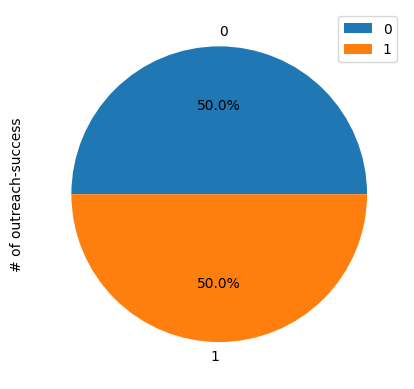

In [23]:
feature_df = train_df.groupby(['outreach-success']).size().reset_index(name='# of ' + 'outreach-success')
feature_df.set_index('outreach-success', inplace=True)
feature_df.plot(y='# of ' + 'outreach-success', kind='pie', autopct="%1.1f%%");

### If we used the initial imbalanced dataset we could continue in different ways.
We could apply oversampling on minority class, undersampling on the majority class, or SMOTE analysis to generate synthetic samples from the minority class. If we had more than 2 classes then we could balance all the classes by running the algorithm n-1 times

In our study, we created a small dataset, in order to save time for the intensive calculations of new features.

Of course, we could use more variations of data and/or even the initial imbalanced dataset, but this input is sufficient for this first study.

### Create input & outputs vectors and split data

In [24]:
input_df = train_df.drop(['outreach-success'], axis=1) # it will be used on model object
input = input_df.values
output = train_df['outreach-success'].values.flatten().astype('int')
# define training and test sets
X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.1, random_state=42)

Regarding models, we choose a simple linear model(Logistic regression), tree-based (XGBoost, Random Forest and Decision Trees), support vectors(SVC) and a simple neural network(MLP).

Note that we don't perform exhaustive hyperparameter tuning, although algorithms like xgboost and mlp have a lot of parameters. That option would be time consuming and is out of scope on this first study.

### Define models

In [25]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('XGBoost', XGBClassifier()))
models.append(('DcsTrees', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('MLP', MLPClassifier()))
models.append(('SVC', SVC()))

### Initialize model object

In [26]:
model_obj = Model(input_df)

### Scale before feeding the model_obj

In [27]:
in_scaler, X_train_scaled = model_obj.scale(X_train)

### K-fold cross validation

In [28]:
results, names = model_obj.k_fold_val(X_train_scaled, y_train, models, k=5, score='accuracy')

-------------Start of Training-------------
LR mean accuracy and std: 0.549054, 0.034777
XGBoost mean accuracy and std: 0.645414, 0.016275
DcsTrees mean accuracy and std: 0.618246, 0.017813
RF mean accuracy and std: 0.625851, 0.017315
MLP mean accuracy and std: 0.614280, 0.018490
SVC mean accuracy and std: 0.584937, 0.015372
-------------End of Training-------------


### Algorithm comparison

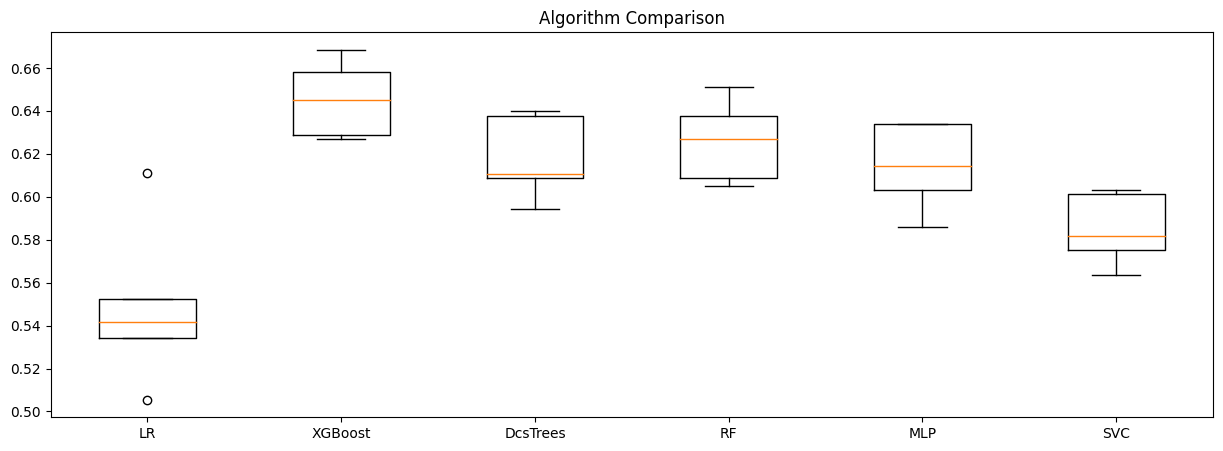

In [29]:
fig = plt.figure(figsize = (15,5));
plt.boxplot(results, labels=names);
plt.title('Algorithm Comparison');

### Comments on algorithms and datasets
- Logistic Regression has approximately 55% accuracy.
- XGBoost has 65% accuracy.
- MLP, Decision Trees and Support vector classifier have around 60%.
- Notice that the deviation on this small training set is greater(bigger boxes). The reason for that is the variability between different training subsets on every fold.
#### In general, the performance is not good, but is better than randomness and a good starting point for further improvements.

## Final training and evaluation
Now, we train the best performing model, create predictions on the test set and evaluate their results.

Using xgboost, which outperforms the others, we can get the explainability of both models.


#### We display 
- the basic metrics
- confusion matrices
- classification reports
- feature importance
- **Area Under the Curve (AUC)**, which is the measure of the ability of a classifier to distinguish between projects and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

### XGBoost Classifier

Accuracy: 0.63192
F1 Score: 0.65653
Precision: 0.64671
Recall: 0.66667
ROC AUC Score: 0.62989
[[ 86  59]
 [ 54 108]]
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       145
           1       0.65      0.67      0.66       162

    accuracy                           0.63       307
   macro avg       0.63      0.63      0.63       307
weighted avg       0.63      0.63      0.63       307



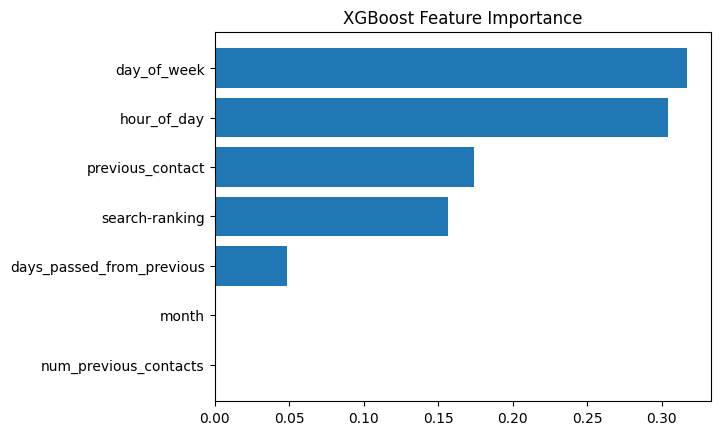

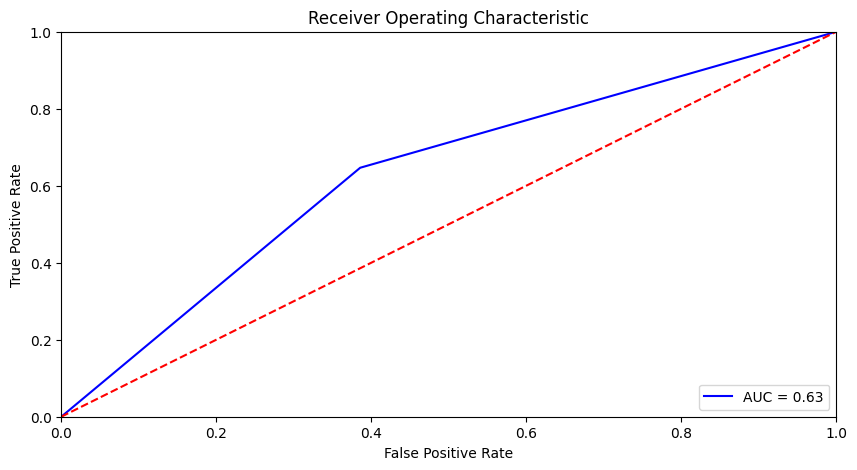

In [30]:
trained_model = model_obj.train_model(XGBClassifier(random_state=42), X_train_scaled, y_train)
y_pred = model_obj.predict_data(trained_model, X_test, in_scaler)
model_obj.important_features('XGBoost', trained_model)
model_obj.print_metrics(y_pred, y_test, limited=False) # if limited==False, classif report and confusion matrix will be printed
model_obj.plot_roc_auc_curve(y_pred, y_test)

## Evaluation, comments and further work
- The f1 score on the positive class is around 66%, which is a good indicator of model's ability to infer successful response.

- Moreover, the areas under curve is around 0.63, which is just a bit better than randomness.

- Note again that the variability of the random undersampled dataset affects the performance of all the models. The proportion we chose, may not properly helps algorithms to learn.

- Further study may include various improvements for better performance, like hyperparameter tuning, feature engineering, more algorithms, training on the whole set and more. We could also create more variables, like grouping *search-ranking* in 3-4 categories separating top experts from the others. Another idea could be to use this grouping of *search-ranking* as a target variable and its correlation with positive responses.

- Regarding the explanation of how the model learned from the input data, **day, hour, previous contact and search ranking** are the most important features on XGBoost. They are all numerical, except the third which is a categorical variable. This was calculated from the coefficients of the model, but we could also use permutation or stepwise selection like we did earlier on the analysis. This step is quite important in order to understand experts behavior and add value to the business intelligence (with A/B tests of new components and more). Specifically, we could use these indicators to re-rank the profiles so that the top experts have the highest probability of responding positively.